### Chess Games
To begin, we need to prepare the data that is readily available for us in `games.csv`. There are 6 columns that will be kept which are turns, white_rating, black_rating, rated, winner and first_move. From all of these columns, we will have to parse the moves column to receive the first_move and then use one hot encoding to successfully run our algorithms on the categorical data. 

Number of entries: 18132
Number of features: 6
   turns  white_rating  black_rating  rated winner  first_move_Nc3  \
1     16          1322          1261   True  black           False   
2     61          1496          1500   True  white           False   
3     61          1439          1454   True  white           False   
4     95          1523          1469   True  white           False   
6     33          1520          1423   True  white           False   
8     66          1439          1392   True  black           False   
9    119          1381          1209   True  white           False   

   first_move_Nf3  first_move_Nh3  first_move_a3  first_move_a4  ...  \
1           False           False          False          False  ...   
2           False           False          False          False  ...   
3           False           False          False          False  ...   
4           False           False          False          False  ...   
6           False           Fals

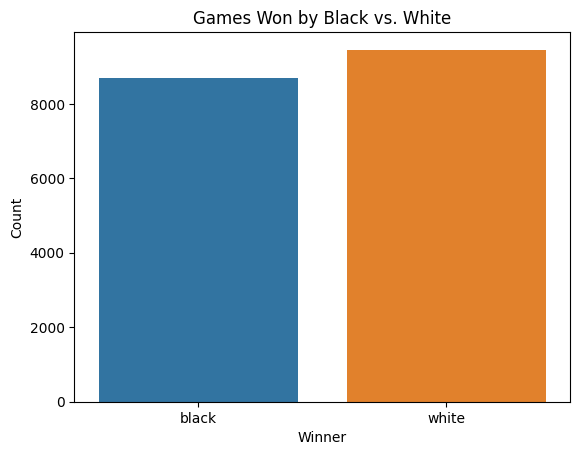

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from graphs import plot_learning_curve
import constants
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load your dataset
d = pd.read_csv('./datasets/games.csv')
# filtered_data = d[(d['turns'] >= 15) | (d['victory_status'] != 'draw') | (d['winner'] != 'draw')].copy()# Use .copy() to ensure you are working on a copy
filtered_data = d[(d['turns'] >= 15) & (d['winner'] != 'draw')].copy()

# Define the target column and set random_state
target_column = 'winner'

# parse out the first move
filtered_data['moves'] = filtered_data['moves'].str.split()
filtered_data['first_move'] = filtered_data['moves'].str[0]
# filtered_data['second_move'] = filtered_data['moves'].str[1] #TODO: If I want to include the second move

# List the columns to keep - and drop the rest 
columns_to_keep = ["turns", "white_rating", "black_rating", "rated", "winner", "first_move"]
data = filtered_data[columns_to_keep]

# Create one-hot encoding for the "first_move" column, and drop the first_move column
one_hot_encoded = pd.get_dummies(data['first_move'], prefix='first_move', drop_first=True)
data_encoded = pd.concat([data, one_hot_encoded], axis=1)
data_encoded = data_encoded.drop(columns=['first_move'])

# Set the X and y for the data 
X = data_encoded.drop(columns=[target_column])
y = data_encoded[target_column]

# Print out data and stats to ensure correct
num_entries = data.shape[0]
print("Number of entries:", num_entries)
num_features = data.shape[1]
print("Number of features:", num_features)
print(data_encoded.head(7))
counts = data_encoded['winner'].value_counts()
print("counts", counts)
sns.countplot(data=data_encoded, x='winner')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.title('Games Won by Black vs. White')
plt.show()

Next we must split the data into the training and tests set. 

In [2]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=constants.TEST_SIZE, random_state=constants.RANDOM_STATE)

Run Scaling for the data to be used in the SVM, NN, and kNN. These are algorithms which always benefit from scaling the data.

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Decision Tree
Train using the values for a decision tree, and then plot the learning curve using the cross validation value set globally.

In [3]:
from dt import dt

# Create a GridSearchCV object for hyperparameter tuning
param_grid = {
    'max_depth': [8,9,7,6,5],  # You can include 'None' for unlimited depth
    'min_samples_split': [2, 5, 3, 13],
    'min_samples_leaf': [1, 5, 9]
}

best_dt_model, best_dt_params = dt(X_train, X_test, y_train, y_test, param_grid)


Decision Tree took 0.0007491111755371094 seconds to execute.

Decision tree train report
               precision    recall  f1-score   support

       black   0.688083  0.488208  0.571164      6954
       white   0.628148  0.796186  0.702254      7551

    accuracy                       0.648535     14505
   macro avg   0.658115  0.642197  0.636709     14505
weighted avg   0.656882  0.648535  0.639407     14505


Decision tree test report
               precision    recall  f1-score   support

       black   0.687666  0.449015  0.543288      1726
       white   0.619600  0.814834  0.703931      1901

    accuracy                       0.640750      3627
   macro avg   0.653633  0.631925  0.623609      3627
weighted avg   0.651991  0.640750  0.627485      3627

Best Hyperparameters: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5}


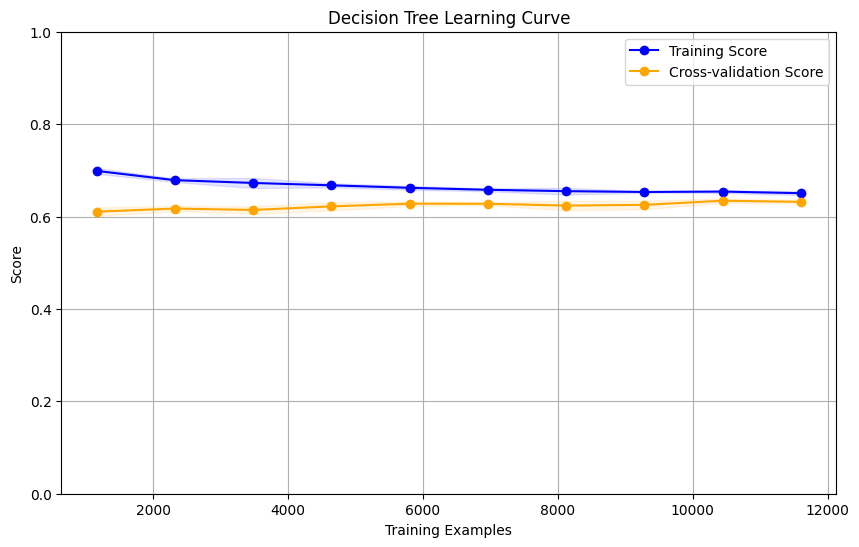

In [4]:
from graphs import plot_learning_curve
plot_learning_curve(best_dt_model, X_train, y_train, scoring='accuracy', title="Decision Tree Learning Curve")

### Neural Networks

In [7]:
from nn import nn

param_grid = {
    'hidden_layer_sizes': [(64,), (64,2)],
    'learning_rate_init': [0.001, 0.01]
}

best_nn_model, best_nn_params = nn(X_train_scaled, X_test_scaled, y_train, y_test, param_grid)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Best Hyperparameters: {'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01}

NN train report
               precision    recall  f1-score   support

       black   0.638711  0.643946  0.641318      6954
       white   0.669602  0.664548  0.667065      7551

    accuracy                       0.654671     14505
   macro avg   0.654156  0.654247  0.654192     14505
weighted avg   0.654792  0.654671  0.654721     14505


NN test report
               precision    recall  f1-score   support

       black   0.639206  0.615875  0.627324      1726
       white   0.662424  0.684377  0.673221      1901

    accuracy                       0.651778      3627
   macro avg   0.650815  0.650126  0.650272      3627
weighted avg   0.651375  0.651778  0.651380      3627

NN took 0.0015301704406738281 seconds to execute.


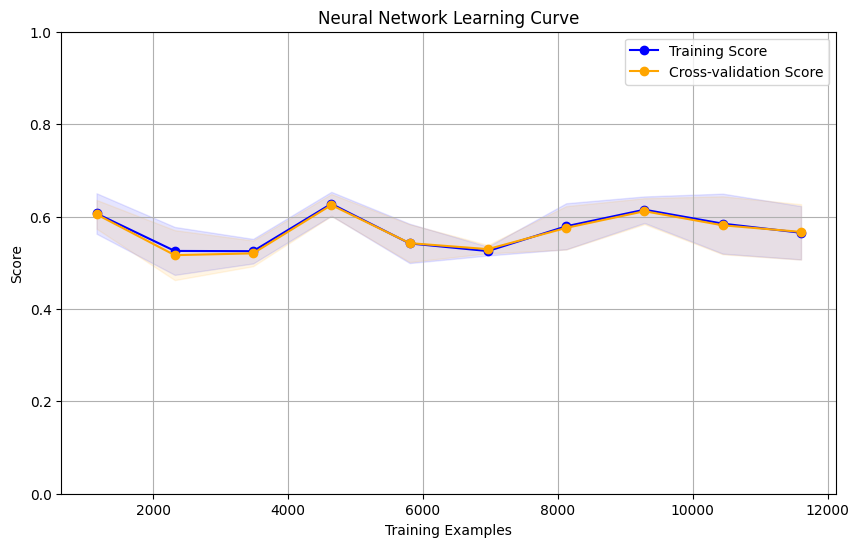

In [8]:
from graphs import plot_learning_curve

plot_learning_curve(best_nn_model, X_train, y_train, scoring='accuracy', title="Neural Network Learning Curve")

### K-Nearest Neighbors
Use the scaled sets for training.

In [3]:
from knn import knn

param_grid = {
    'n_neighbors': [89, 90, 91],
    'weights': ['distance'],
    'p': [1, 2]
}

best_knn_model, best_knn_params = knn(X_train_scaled, X_test_scaled, y_train, y_test, param_grid)


Best Hyperparameters: {'n_neighbors': 90, 'p': 1, 'weights': 'distance'}

knn train report
               precision    recall  f1-score   support

       black   1.000000  1.000000  1.000000      6954
       white   1.000000  1.000000  1.000000      7551

    accuracy                       1.000000     14505
   macro avg   1.000000  1.000000  1.000000     14505
weighted avg   1.000000  1.000000  1.000000     14505


knn test report
               precision    recall  f1-score   support

       black   0.682299  0.598494  0.637654      1726
       white   0.672030  0.746975  0.707524      1901

    accuracy                       0.676317      3627
   macro avg   0.677164  0.672734  0.672589      3627
weighted avg   0.676917  0.676317  0.674275      3627

Decision Tree took 0.20247602462768555 seconds to execute.
Decision Tree took 4.7793662548065186 seconds to execute.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


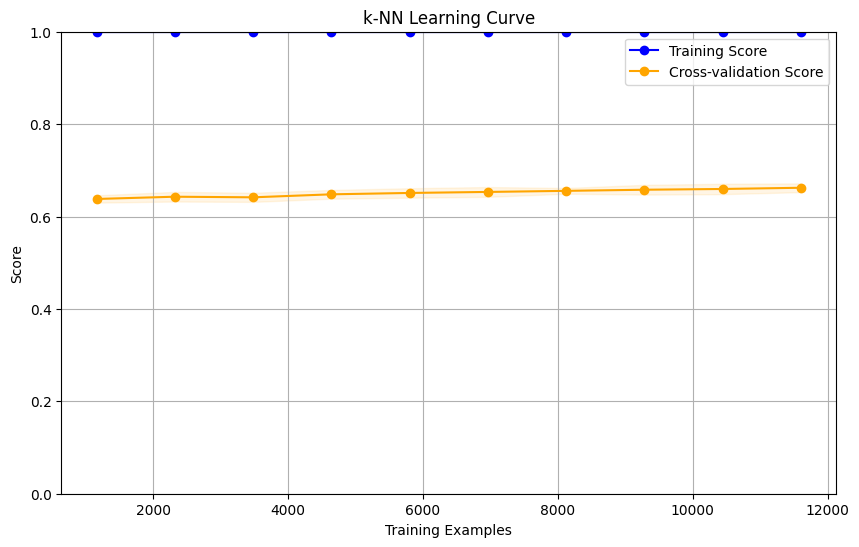

In [34]:
from graphs import plot_learning_curve
plot_learning_curve(best_knn_model, X_train, y_train, scoring='accuracy', title="k-NN Learning Curve")

### Boosted Decision Tree Classifier

In [4]:
from dt import ada_boosted_dt

# Define the parameter grid for AdaBoost
param_grid = {
    'base_estimator__max_depth': [None, 10, 20],  # Adjust max_depth as needed
    'n_estimators': [25, 50, 55],  # Number of Decision Trees in the ensemble
    'learning_rate': [0.01, 0.1, 1.0]
}

best_bdt_model, best_bdt_params = ada_boosted_dt(X_train, X_test, y_train, y_test, param_grid)



Best AdaBoost Decision Tree Hyperparameters: {'base_estimator__max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 50}

NN train report
               precision    recall  f1-score   support

       black   1.000000  1.000000  1.000000      6954
       white   1.000000  1.000000  1.000000      7551

    accuracy                       1.000000     14505
   macro avg   1.000000  1.000000  1.000000     14505
weighted avg   1.000000  1.000000  1.000000     14505


NN test report
               precision    recall  f1-score   support

       black   0.842857  0.820394  0.831474      1726
       white   0.840781  0.861126  0.850832      1901

    accuracy                       0.841742      3627
   macro avg   0.841819  0.840760  0.841153      3627
weighted avg   0.841769  0.841742  0.841620      3627

DTADA Boosting took 0.016002893447875977 seconds to execute.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/

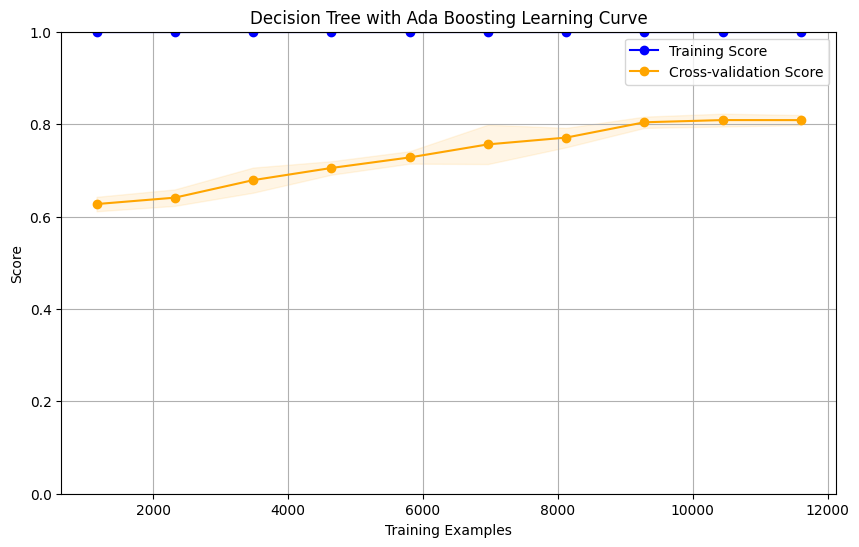

In [5]:
from graphs import plot_learning_curve
plot_learning_curve(best_bdt_model, X_train, y_train, scoring='accuracy', title="Decision Tree with Ada Boosting Learning Curve")

### Support Vector Machine


In [6]:
from svm import svm

# Set the param grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'degree': [2, 3, 4]
}

# Pass the scaled data to the svm
best_svm_model, best_svm_params = svm(X_train_scaled, X_test_scaled, y_train, y_test, param_grid)


Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

SVM train report
               precision    recall  f1-score   support

       black   0.654867  0.592000  0.621849       250
       white   0.627737  0.688000  0.656489       250

    accuracy                       0.640000       500
   macro avg   0.641302  0.640000  0.639169       500
weighted avg   0.641302  0.640000  0.639169       500


SVM test report
               precision    recall  f1-score   support

       black   0.636305  0.574739  0.603957      1726
       white   0.645068  0.701736  0.672210      1901

    accuracy                       0.641301      3627
   macro avg   0.640687  0.638238  0.638084      3627
weighted avg   0.640898  0.641301  0.639730      3627

Decision Tree took 1.3113021850585938e-05 seconds to execute.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


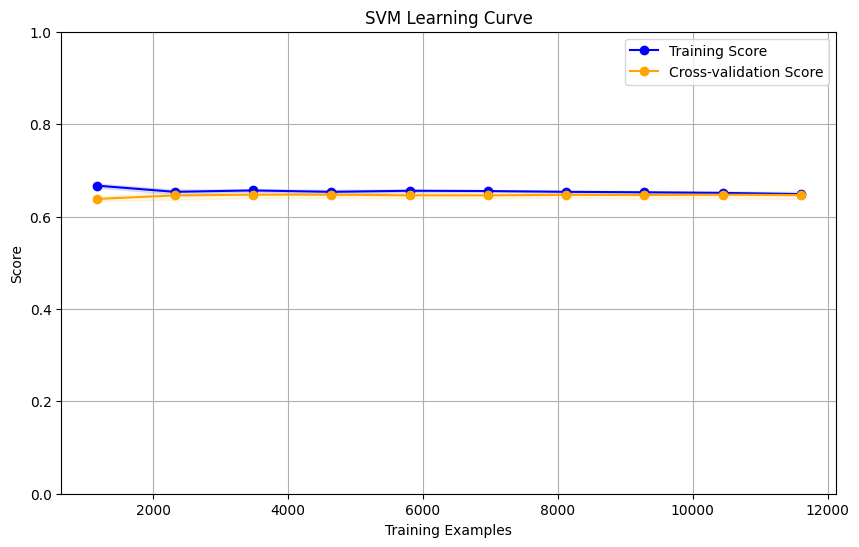

In [20]:
from graphs import plot_learning_curve
plot_learning_curve(best_svm_model, X_train_scaled, y_train, scoring='accuracy', title="SVM Learning Curve")